# ROC Curve - Multiclass
Vinicius Trevisan - 2022

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

## Functions
Slightly modified from the binary classifier case

In [3]:
def calculate_tpr_fpr(y_real, y_pred):
    '''
    Calculates the True Positive Rate (tpr) and the True Negative Rate (fpr) based on real and predicted observations
    
    Args:
        y_real: The list or series with the real classes
        y_pred: The list or series with the predicted classes
        
    Returns:
        tpr: The True Positive Rate of the classifier
        fpr: The False Positive Rate of the classifier
    '''
    
    # Calculates the confusion matrix and recover each element
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    
    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate
    
    return tpr, fpr

In [4]:
def get_all_roc_coordinates(y_real, y_proba):
    '''
    Calculates all the ROC Curve coordinates (tpr and fpr) by considering each point as a threshold for the predicion of the class.
    
    Args:
        y_real: The list or series with the real classes.
        y_proba: The array with the probabilities for each class, obtained by using the `.predict_proba()` method.
        
    Returns:
        tpr_list: The list of TPRs representing each threshold.
        fpr_list: The list of FPRs representing each threshold.
    '''
    tpr_list = [0]
    fpr_list = [0]
    for i in range(len(y_proba)):
        threshold = y_proba[i]
        y_pred = y_proba >= threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list

In [5]:
def plot_roc_curve(tpr, fpr, scatter = True, ax = None):
    '''
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).
    
    Args:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted with the line (default = True).
    '''
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()
    
    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'green', ax = ax)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

## Multiclass classification evaluation with KS test

### Creating a synthetic dataset

In [6]:
scale = 3.5
size = 500

In [7]:
class1_x = np.random.normal(loc = 10, scale = scale, size = size)
class1_y = np.random.normal(loc = 1, scale = scale, size = size)

In [8]:
class2_x = np.random.normal(loc = 1, scale = scale, size = size)
class2_y = np.random.normal(loc = 5, scale = scale, size = size)

In [9]:
class3_x = np.random.normal(loc = 10, scale = scale, size = size)
class3_y = np.random.normal(loc = 10, scale = scale, size = size)

In [10]:
df_class1 = pd.DataFrame({'x' : class1_x, 'y' : class1_y, 'class': 'apple'})
df_class2 = pd.DataFrame({'x' : class2_x, 'y' : class2_y, 'class': 'banana'})
df_class3 = pd.DataFrame({'x' : class3_x, 'y' : class3_y, 'class': 'orange'})
df = df_class1.append(df_class2, ignore_index = True)
df = df.append(df_class3, ignore_index = True)

/tmp/ipykernel_9527/194776675.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df_class1.append(df_class2, ignore_index = True)
/tmp/ipykernel_9527/194776675.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_class3, ignore_index = True)


In [25]:
df.head()

,x,y,class
0,5.829832,-1.334041,apple
1,10.124288,-4.624703,apple
2,10.068105,-5.079795,apple
3,6.096588,2.570978,apple
4,12.253892,7.012992,apple


<AxesSubplot: xlabel='x', ylabel='y'>

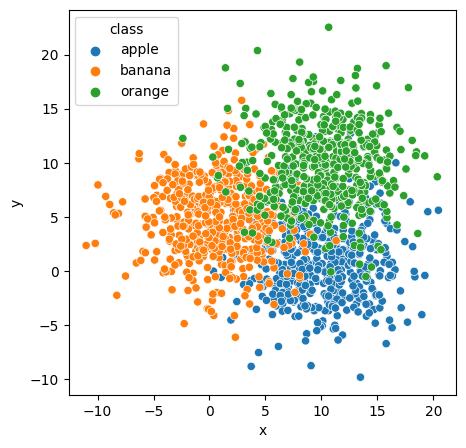

In [11]:
# Plot them to show how much they intersect
plt.figure(figsize=(5, 5))
sns.scatterplot(x = 'x', y = 'y', hue = 'class', data = df)

In [12]:
X = df[['x', 'y']]
y = df['class']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

### Fits the model and make the predictions

In [14]:
model_multiclass = RandomForestClassifier(n_estimators = 50, criterion = 'gini')

In [15]:
model_multiclass.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50)

In [16]:
y_pred = model_multiclass.predict(X_test)

In [17]:
y_proba = model_multiclass.predict_proba(X_test)

## ROC Curve - One vs Rest (OvR)
Compares each class with the rest of the classes

In [18]:
classes = model_multiclass.classes_
classes

array(['apple', 'banana', 'orange'], dtype=object)

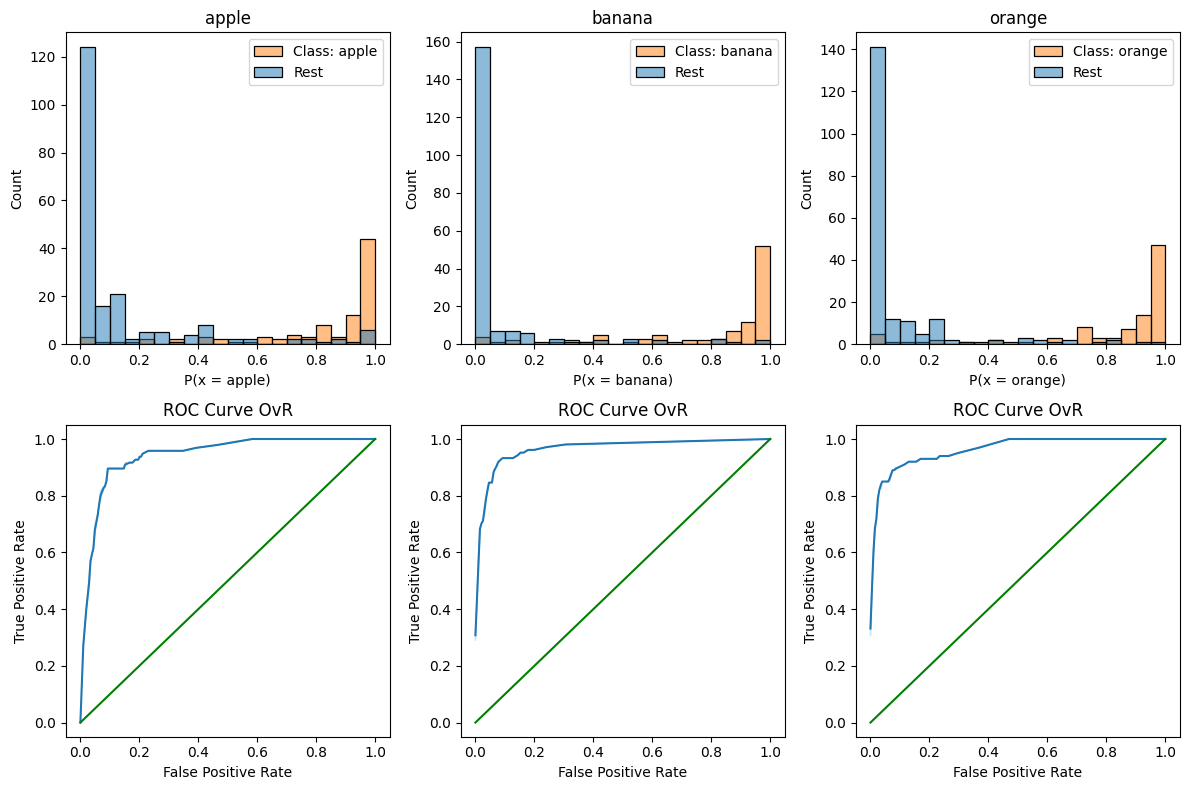

In [19]:
# Plots the Probability Distributions and the ROC Curves One vs Rest
plt.figure(figsize = (12, 8))
bins = [i/20 for i in range(20)] + [1]
roc_auc_ovr = {}

for i in range(len(classes)):
    # Gets the class
    c = classes[i]
    
    # Prepares an auxiliar dataframe to help with the plots
    df_aux = X_test.copy()
    df_aux['class'] = [1 if y == c else 0 for y in y_test]
    df_aux['prob'] = y_proba[:, i]
    df_aux = df_aux.reset_index(drop = True)
    
    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(2, 3, i+1)
    sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(c)
    ax.legend([f"Class: {c}", "Rest"])
    ax.set_xlabel(f"P(x = {c})")
    
    # Calculates the ROC Coordinates and plots the ROC Curves
    ax_bottom = plt.subplot(2, 3, i+4)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
    ax_bottom.set_title("ROC Curve OvR")
    
    # Calculates the ROC AUC OvR
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])
    
plt.tight_layout()

In [29]:
tpr[0:10], fpr[0:10]

([0, 1.0, 0.85, 0.43, 1.0, 0.73, 1.0, 0.3, 0.93, 0.47],
 [0,
  1.0,
  0.028846153846153855,
  0.0,
  1.0,
  0.009615384615384581,
  1.0,
  0.0,
  0.10576923076923073,
  0.009615384615384581])

In [27]:
df_aux.head(10)

,x,y,class,prob
0,1.871833,0.834052,0,0.00
1,3.119800,3.442602,0,0.60
2,11.023690,13.298110,1,0.98
3,-0.925375,0.934955,0,0.00
4,13.361769,6.086978,1,0.78
5,-2.691569,3.292023,0,0.00
6,9.236405,14.414956,1,1.00
7,10.596579,4.176359,1,0.18
8,7.124965,11.898660,1,0.96
9,17.777574,16.944438,1,1.00


In [20]:
# Displays the ROC AUC for each class
avg_roc_auc = 0
i = 0
for k in roc_auc_ovr:
    avg_roc_auc += roc_auc_ovr[k]
    i += 1
    print(f"{k} ROC AUC OvR: {roc_auc_ovr[k]:.4f}")
print(f"average ROC AUC OvR: {avg_roc_auc/i:.4f}")

apple ROC AUC OvR: 0.9413
banana ROC AUC OvR: 0.9644
orange ROC AUC OvR: 0.9620
average ROC AUC OvR: 0.9559


In [21]:
# Compares with sklearn (average only)
# "Macro" average = unweighted mean
roc_auc_score(y_test, y_proba, labels = classes, multi_class = 'ovr', average = 'macro')

0.9558869840885071

## ROC Curve - One vs One (OvO)
Compares each possible combination of the classes, two at a time

In [22]:
classes_combinations = []
class_list = list(classes)
for i in range(len(class_list)):
    for j in range(i+1, len(class_list)):
        classes_combinations.append([class_list[i], class_list[j]])
        classes_combinations.append([class_list[j], class_list[i]])
classes_combinations

[['apple', 'banana'],
 ['banana', 'apple'],
 ['apple', 'orange'],
 ['orange', 'apple'],
 ['banana', 'orange'],
 ['orange', 'banana']]

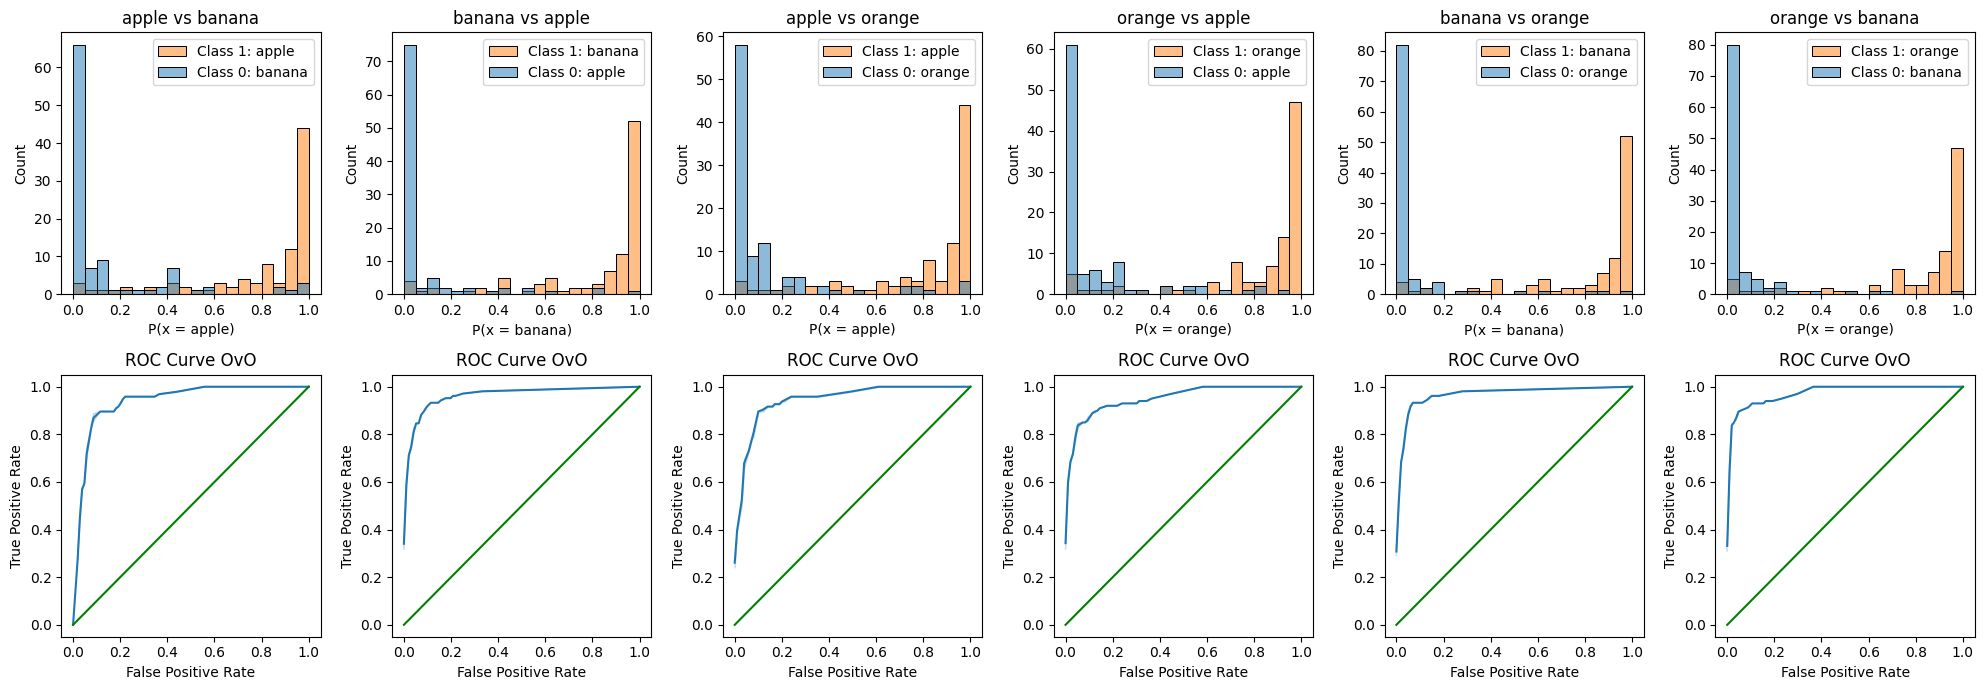

In [23]:
# Plots the Probability Distributions and the ROC Curves One vs ONe
plt.figure(figsize = (20, 7))
bins = [i/20 for i in range(20)] + [1]
roc_auc_ovo = {}

for i in range(len(classes_combinations)):
    # Gets the class
    comb = classes_combinations[i]
    c1 = comb[0]
    c2 = comb[1]
    c1_index = class_list.index(c1)
    title = c1 + " vs " +c2
    
    # Prepares an auxiliar dataframe to help with the plots
    df_aux = X_test.copy()
    df_aux['class'] = y_test
    df_aux['prob'] = y_proba[:, c1_index]
    
    # Slices only the subset with both classes
    df_aux = df_aux[(df_aux['class'] == c1) | (df_aux['class'] == c2)]
    df_aux['class'] = [1 if y == c1 else 0 for y in df_aux['class']]
    df_aux = df_aux.reset_index(drop = True)
    
    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(2, 6, i+1)
    sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(title)
    ax.legend([f"Class 1: {c1}", f"Class 0: {c2}"])
    ax.set_xlabel(f"P(x = {c1})")
    
    # Calculates the ROC Coordinates and plots the ROC Curves
    ax_bottom = plt.subplot(2, 6, i+7)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
    ax_bottom.set_title("ROC Curve OvO")
    
    # Calculates the ROC AUC OvO
    roc_auc_ovo[title] = roc_auc_score(df_aux['class'], df_aux['prob'])
    
plt.tight_layout()

In [24]:
# Displays the ROC AUC for each class
avg_roc_auc = 0
i = 0
for k in roc_auc_ovo:
    avg_roc_auc += roc_auc_ovo[k]
    i += 1
    print(f"{k} ROC AUC OvO: {roc_auc_ovo[k]:.4f}")
print(f"average ROC AUC OvO: {avg_roc_auc/i:.4f}")

apple vs banana ROC AUC OvO: 0.9382
banana vs apple ROC AUC OvO: 0.9624
apple vs orange ROC AUC OvO: 0.9444
orange vs apple ROC AUC OvO: 0.9508
banana vs orange ROC AUC OvO: 0.9663
orange vs banana ROC AUC OvO: 0.9723
average ROC AUC OvO: 0.9558


In [25]:
# Compares with sklearn (average only)
# "Macro" average = unweighted mean
roc_auc_score(y_test, y_proba, labels = classes, multi_class = 'ovo', average = 'macro')

0.9408779995138192